In [25]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_USE_LEGACY_KERAS']='1' 

In [26]:
input_default_json_conf_file='cnn_face_emotion_multiple_training_default.json';

# Bibliotecas externas

In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import json

import platform

# Biblioteca local

In [28]:
import sys
sys.path.append('../library');

# Uso de GPU

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Load default DATA

In [30]:
## Load json conf json file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variables

In [31]:
#################################################################

## Seed for the random variables
seed_number=0;

## Dataset 
multiple_tuning = DATA['multiple_tuning'];

dataset_base_test_dir    = DATA['dataset_test_base_dir'];
dataset_labels_test_file = DATA['dataset_test_labels_file'];

multiple_dataset_name    = DATA['multiple_dataset_name'];

## Training hyperparameters
EPOCAS     = DATA["epochs"];
BATCH_SIZE = DATA["batch_size"];

## Model of network
## 'mobilenet_v3', 'efficientnet_b3', 'inception_v3', 'inception_resnet_v2', 'resnet_v2_50'
model_type = DATA["model_type"];

## Output
output_base_dir = DATA["output_base_dir"];


# Parametros de entrada

In [32]:


for n in range(len(sys.argv)):
    if   sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--model':
        model_type=sys.argv[n+1];
    elif sys.argv[n]=='--epochs':
        EPOCAS=int(sys.argv[n+1]);
    elif sys.argv[n]=='--batch-size':
        BATCH_SIZE=int(sys.argv[n+1]);
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
        
print('         multiple_tuning:')
print(json.dumps(multiple_tuning,sort_keys=True, indent=4))
print('   dataset_base_test_dir:',dataset_base_test_dir)
print('dataset_labels_test_file:',dataset_labels_test_file)
print('   multiple_dataset_name:',multiple_dataset_name)
print('              model_type:',model_type)
print('                  EPOCAS:',EPOCAS)
print('              BATCH_SIZE:',BATCH_SIZE)
print('         output_base_dir:',output_base_dir)


         multiple_tuning:
[
    {
        "base_dir": "/media/fernando/Expansion/DATASET/EXTERN/FACE/AffectNet-Sample/input/affectnetsample/train_class",
        "labels_file": "training_labels.csv",
        "name": "affectnet"
    },
    {
        "base_dir": "/media/fernando/Expansion/DATASET/EXTERN/FACE/fer2013/archive/train",
        "labels_file": "training_labels.csv",
        "name": "fer2013"
    },
    {
        "base_dir": "/media/fernando/Expansion/DATASET/TESE/FACE-EMOTION/mcfer/archive/train",
        "labels_file": "training_labels.csv",
        "name": "mcfer_v1.0"
    },
    {
        "base_dir": "/media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FACE",
        "labels_file": "train.csv",
        "name": "ber2024-face"
    }
]
   dataset_base_test_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FACE
dataset_labels_test_file: test.csv
   multiple_dataset_name: multiple_ber2024-face
              model_type: mobilenet_v3
                  EPOCAS: 

# Set seed of random variables


In [33]:
np.random.seed(seed_number)
tf.keras.utils.set_random_seed(seed_number);

# Defining directories

In [34]:
output_dir = os.path.join(output_base_dir,multiple_dataset_name,'multiple_training_validation_holdout',model_type);

os.makedirs(output_dir,exist_ok = True);

# Loop



Coarse dataset affectnet
                        filename     label
0      class007/image0000006.jpg  class007
1      class004/image0000020.jpg  class004
2      class002/image0000001.jpg  class002
3      class003/image0000013.jpg  class003
4      class005/image0000284.jpg  class005
...                          ...       ...
37548  class004/image0034977.jpg  class004
37549  class002/image0012067.jpg  class002
37550  class003/image0030491.jpg  class003
37551  class005/image0040960.jpg  class005
37552  class001/image0017441.jpg  class001

[37553 rows x 2 columns]
                                          filename     label
0      person4/negative/frame_count219_cam0_p0.png  negative
1         person3/neutro/frame_count37_cam2_p0.png    neutro
2          person5/pain/frame_count297_cam1_p0.png      pain
3      person8/negative/frame_count336_cam1_p0.png  negative
4        person8/neutro/frame_count142_cam2_p0.png    neutro
...                                            ...       ...
1665

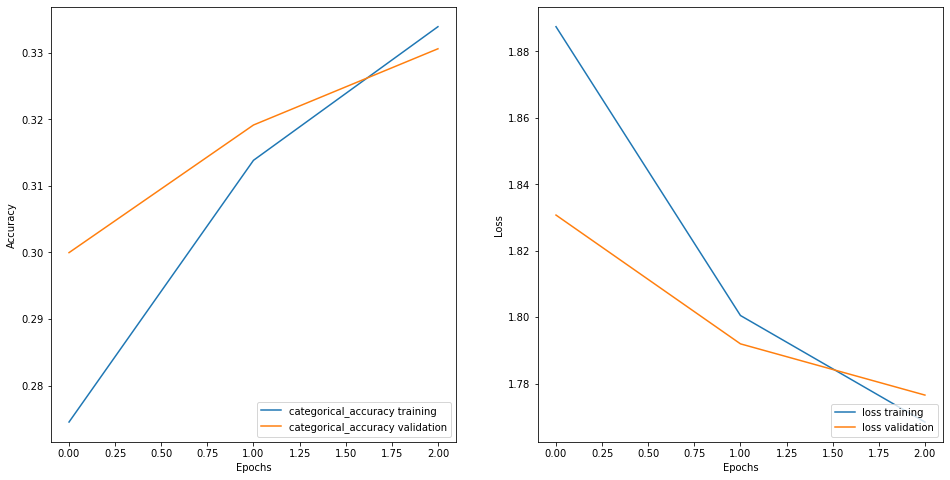

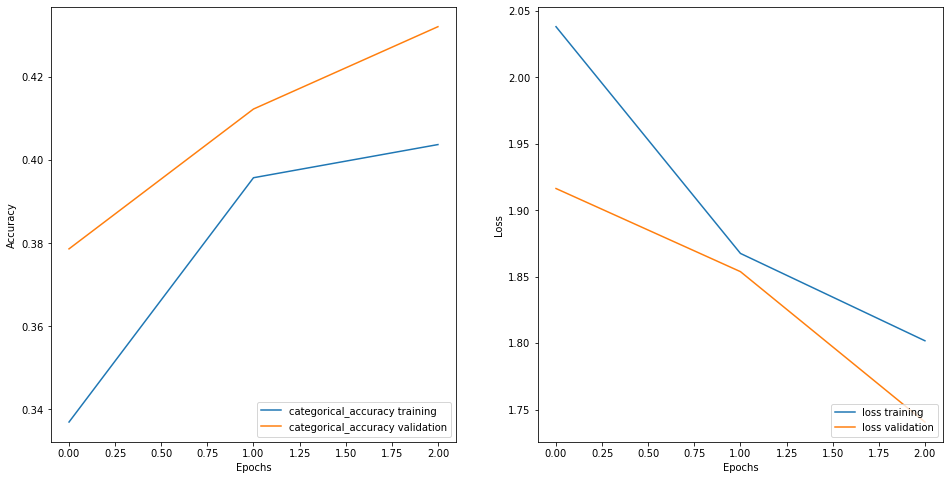

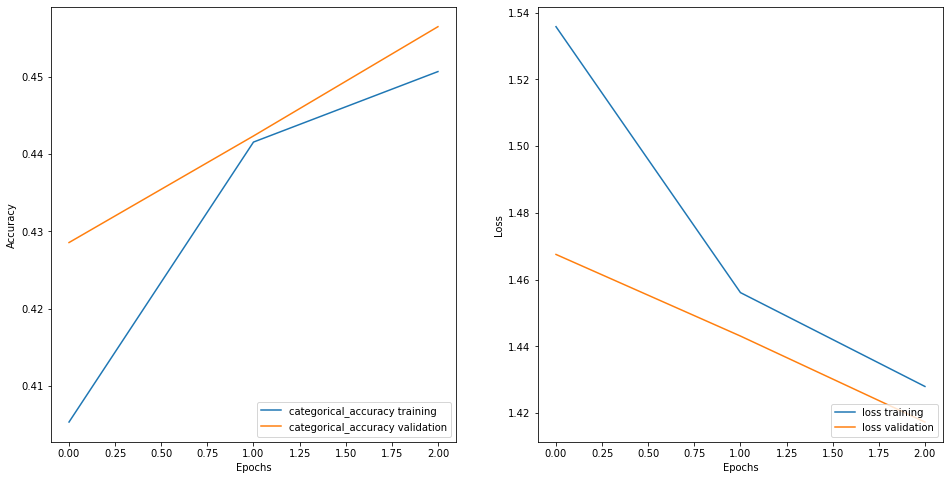

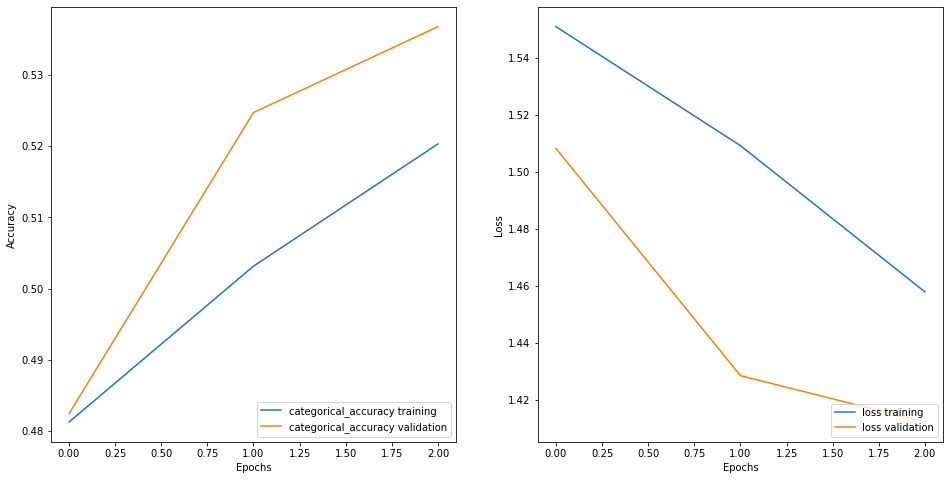

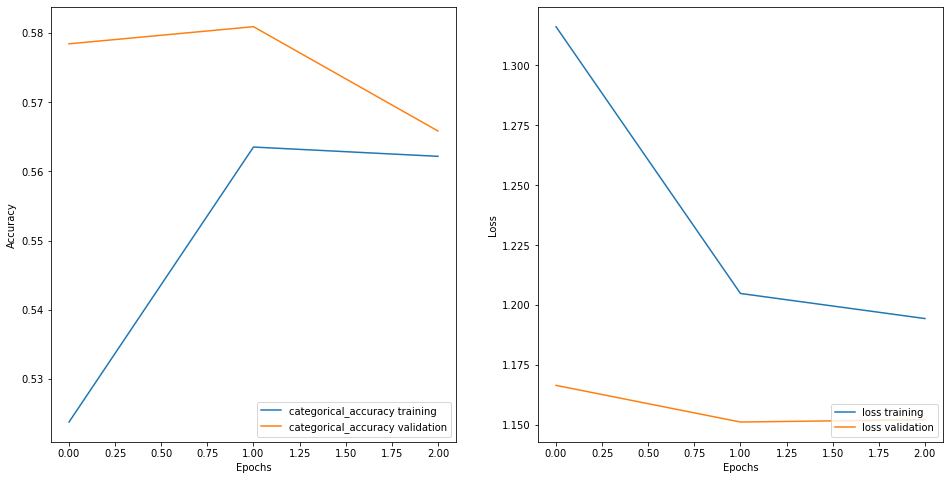

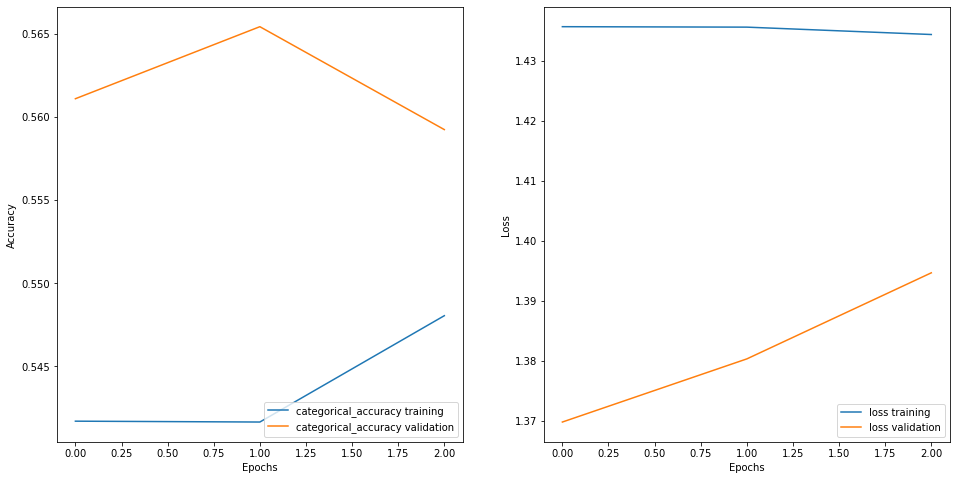

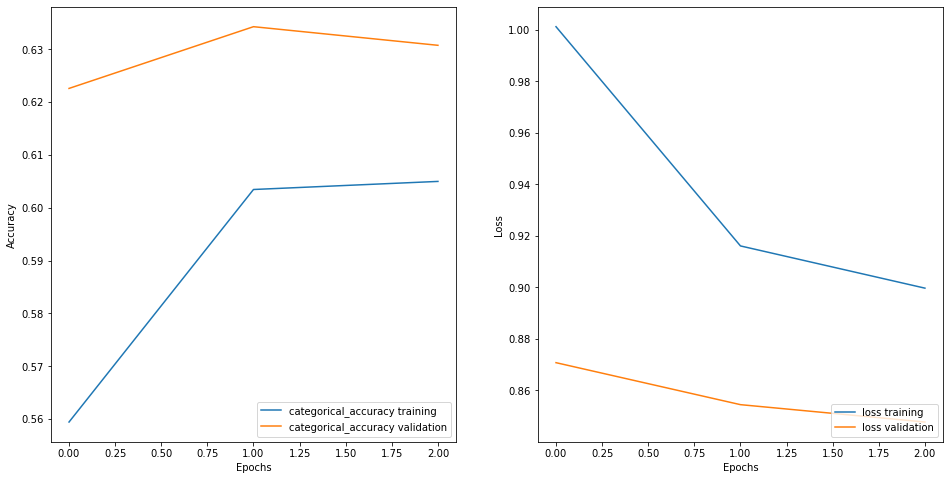

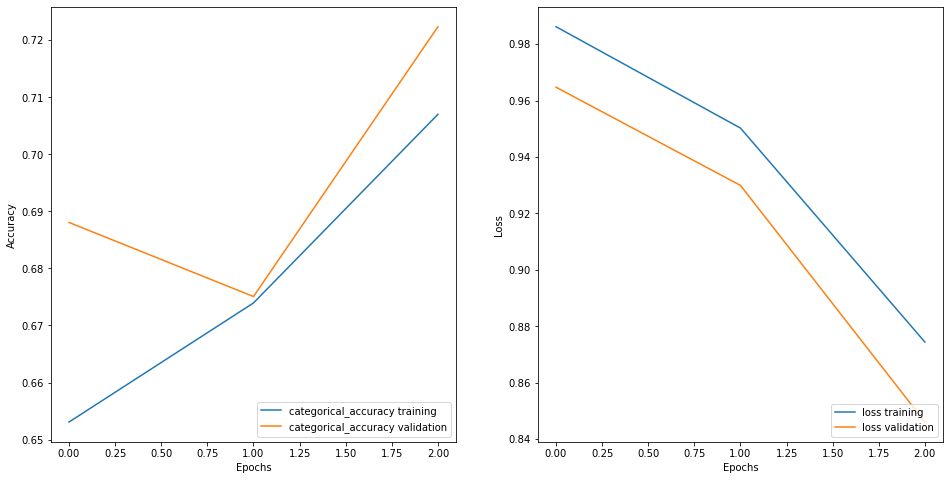

In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import FaceEmotion4Lib.lib_model as mpp
import matplotlib.pyplot as plt

idg    = ImageDataGenerator(rescale=1./255,
                            rotation_range = 10,
                            width_shift_range= 0.07,
                            height_shift_range= 0.07,
                            horizontal_flip=True,
                            shear_range=1.25,
                            zoom_range = [0.75, 1.25]
                            )

idg_val = ImageDataGenerator(rescale=1./255 )


idg_test= ImageDataGenerator(rescale=1./255 );

best_model_file=os.path.join(output_dir,'model.h5');

for c_count,coarse in enumerate(multiple_tuning):
    dataset_base_dir=coarse['base_dir'];
    dataset_labels_file=coarse['labels_file'];
    coarse_name=coarse['name'];

    print('\n\nCoarse dataset',coarse_name)
    
    # Load filenames and labels
    train_val_data = pd.read_csv(os.path.join(dataset_base_dir,dataset_labels_file));
    print(train_val_data)

    # Load test filenames and labels
    test_data = pd.read_csv(os.path.join(dataset_base_test_dir,dataset_labels_test_file));
    print(test_data)
    
    # Setting labels
    Y = train_val_data[['label']];
    L=np.shape(Y)[0];

    # split
    training_data, validation_data = train_test_split(train_val_data, test_size=0.2,shuffle=True, stratify=Y)
    
    # CREATE NEW MODEL
    if c_count==0:
        if   coarse_name=='fer2013':
            model, target_size = mpp.create_model(  file_of_weight='',
                                                    load_weights=False,
                                                    model_type=model_type,
                                                    nout=7,
                                                    tuning_feature_extractor=False);
        elif coarse_name=='affectnet':
            model, target_size = mpp.create_model(  file_of_weight='',
                                                    load_weights=False,
                                                    model_type=model_type,
                                                    nout=8,
                                                    tuning_feature_extractor=False);
        elif coarse_name=='mcfer_v1.0':
            model, target_size = mpp.create_model(  file_of_weight='',
                                                    load_weights=False,
                                                    model_type=model_type,
                                                    nout=7,
                                                    tuning_feature_extractor=False);
        elif coarse_name=='ber2024-face':
            model, target_size = mpp.create_model(  file_of_weight='',
                                                    load_weights=False,
                                                    model_type=model_type,
                                                    nout=4,
                                                    tuning_feature_extractor=False);
        else:
            print('Error in the dataset name.');
            exit();
    else:
        model.pop();
        
        if   coarse_name=='fer2013':
            model.add(tf.keras.layers.Dense(7,activation='softmax'));
        
        elif coarse_name=='affectnet':
            model.add(tf.keras.layers.Dense(8,activation='softmax'));
        
        elif coarse_name=='mcfer_v1.0':
            model.add(tf.keras.layers.Dense(7,activation='softmax'));
        
        elif coarse_name=='ber2024-face':
            model.add(tf.keras.layers.Dense(4,activation='softmax'));
        
        else:
            print('Error in the dataset name.');
            exit();
        
        model.layers[0].trainable = False;
            
    print('model.input_shape:',model.input_shape);
    
    model.summary()
    
    mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats_'+str(c_count)+'_'+coarse_name+'.m'));
    
    train_data_generator = idg.flow_from_dataframe( training_data, 
                                                    directory = dataset_base_dir,
                                                    target_size=target_size,
                                                    x_col = "filename", 
                                                    y_col = "label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    shuffle = True);
    
    valid_data_generator  = idg_val.flow_from_dataframe(validation_data, 
                                                        directory = dataset_base_dir,
                                                        target_size=target_size,
                                                        x_col = "filename", 
                                                        y_col = "label",
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical",
                                                        shuffle = True);
    
    test_data_generator  = idg_test.flow_from_dataframe(test_data, 
                                                        directory = dataset_base_test_dir,
                                                        target_size=target_size,
                                                        x_col = "filename", 
                                                        y_col = "label",
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical",
                                                        shuffle = False);

    # COMPILE NEW MODEL
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_file, 
                                                    save_weights_only=True,
                                                    monitor='val_categorical_accuracy', 
                                                    save_best_only=True, 
                                                    verbose=1);
    
    log_dir = os.path.join(output_dir,"logs","fit", str(c_count)+'_'+coarse_name+'-'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(train_data_generator,
                        epochs=EPOCAS,
                        validation_data=valid_data_generator,
                        callbacks=[checkpoint,tensorboard_callback],
                        verbose=1
                        );
    
    
    mpp.save_model_history( history,
                            os.path.join(output_dir,"historical_"+str(c_count)+'_'+coarse_name+".csv"),
                            show=False,
                            labels=['categorical_accuracy','loss']);
    
    #####################################################################
    #tf.keras.backend.clear_session();
    
    model.load_weights(best_model_file);
    model.layers[0].trainable = True;
    
    #necessary for these changes to take effect
    model.compile(  loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['categorical_accuracy'])
    
    model.summary();

    log_dir = os.path.join(output_dir,"logs","fit", str(c_count)+'_'+coarse_name+'-fine_tunning-'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"));
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    history = model.fit(train_data_generator,
                        epochs=EPOCAS,
                        validation_data=valid_data_generator,
                        callbacks=[checkpoint,tensorboard_callback],
                        verbose=1
                        );
    
    
    mpp.save_model_history( history,
                            os.path.join(output_dir,"historical_"+str(c_count)+'_'+coarse_name+"-fine_tuning.csv"),
                            show=False,
                            labels=['categorical_accuracy','loss']);

# Evaluate best model

In [36]:
# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights(best_model_file);
data_results=dict();

# Evaluate training
results = model.evaluate(train_data_generator)
results = dict(zip(model.metrics_names,results))
print('training',results,"\n\n");
for key,value in results.items():
    data_results['train_'+key]=value;

# Evaluate validation
results = model.evaluate(valid_data_generator)
results = dict(zip(model.metrics_names,results))
print('validation',results,"\n\n");
for key,value in results.items():
    data_results['val_'+key]=value;

# Evaluate testing
results = model.evaluate(test_data_generator)
results = dict(zip(model.metrics_names,results))
print('testing',results,"\n\n");
for key,value in results.items():
    data_results['test_'+key]=value;

data_results['number_of_parameters']=mpp.get_model_parameters(model);

# final all json
with open(os.path.join(output_dir,"training_data_results.json"), 'w') as f:
    json.dump(data_results, f,indent=4);
    f.close()

# final test txt
with open(os.path.join(output_dir,"results_testing.txt"), 'w') as f: 
    for key, value in results.items(): 
        f.write('%s=%s;\n' % (key, value));
    f.close()

tf.keras.backend.clear_session()

1348/1348 [==============================] - 134s 100ms/step - loss: 0.8869 - categorical_accuracy: 0.7064
training {'loss': 0.8869045376777649, 'categorical_accuracy': 0.7063624262809753} 


337/337 [==============================] - 7s 21ms/step - loss: 0.8460 - categorical_accuracy: 0.7224
validation {'loss': 0.8460370898246765, 'categorical_accuracy': 0.722366452217102} 


1041/1041 [==============================] - 318s 306ms/step - loss: 0.8552 - categorical_accuracy: 0.7186
testing {'loss': 0.8551958799362183, 'categorical_accuracy': 0.7185999155044556} 




1041/1041 [==============================] - 22s 20ms/step
              precision    recall  f1-score   support

    negative       0.64      0.60      0.62      4208
     neutral       0.76      0.73      0.75      4424
        pain       0.77      0.56      0.65      3869
    positive       0.71      0.97      0.82      4155

    accuracy                           0.72     16656
   macro avg       0.72      0.72      0.71     16656
weighted avg       0.72      0.72      0.71     16656



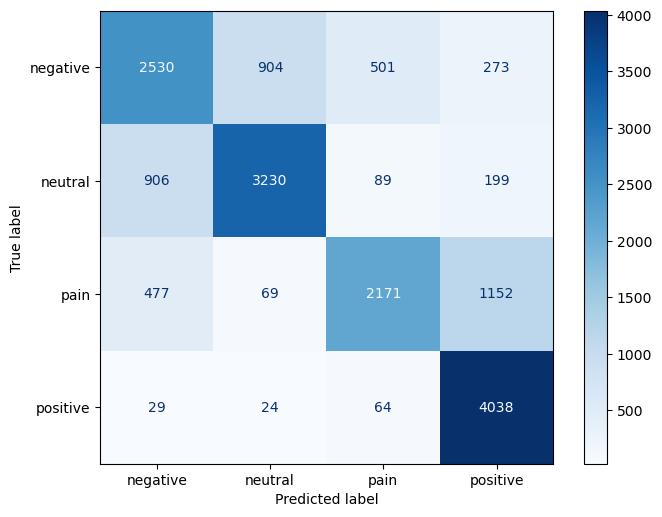

In [38]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

if   coarse_name=='fer2013':
    target_names = ['angry','disgusted','fearful','happy','neutral','sad','surprised'];
elif coarse_name=='affectnet':
    target_names = ['neutral','happy','sad','surprised','fearful','disgusted','angry','unknown'];
elif coarse_name=='mcfer_v1.0':
    target_names = ['angry','disgusted','fearful','happy','neutral','sad','surprised'];
elif coarse_name=='ber2024-face':
    target_names = ['negative','neutral','pain','positive'];
else:
    print('Error in the dataset name.');
    exit();

# Predict
Y_pred = model.predict(test_data_generator,verbose=1);
y_pred = np.argmax(Y_pred, axis=1);

# Confusion matrix

CM=confusion_matrix(test_data_generator.classes, y_pred);

fname=os.path.join(output_dir,"confusion_matrix.eps");
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=target_names)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.savefig(fname)

cm_dict=dict();
cm_dict['matrix']=CM.tolist();
cm_dict['label']=target_names;
# final all json
with open(os.path.join(output_dir,"confusion_matrix.json"), 'w') as f:
    json.dump(cm_dict, f,indent=4);
    f.close()

# Classification report
fname=os.path.join(output_dir,"classification_report.txt")
str_dat=classification_report(test_data_generator.classes, y_pred, target_names=target_names);
print(str_dat)
with open(fname, 'w') as f: 
    f.write('%s\n' % str_dat);
    f.close()

In [39]:

tmp_name='model_'+model_type+'.h5';

os.rename(best_model_file,os.path.join(output_dir,tmp_name));

In [44]:
'''
if   coarse_name=='fer2013':
    model, target_size = mpp.create_model(  file_of_weight=os.path.join(output_dir,tmp_name),
                                            load_weights=False,
                                            model_type=model_type,
                                            nout=7,
                                            tuning_feature_extractor=False);
elif coarse_name=='affectnet':
    model, target_size = mpp.create_model(  file_of_weight=os.path.join(output_dir,tmp_name),
                                            load_weights=False,
                                            model_type=model_type,
                                            nout=8,
                                            tuning_feature_extractor=False);
elif coarse_name=='mcfer_v1.0':
    model, target_size = mpp.create_model(  file_of_weight=os.path.join(output_dir,tmp_name),
                                            load_weights=False,
                                            model_type=model_type,
                                            nout=7,
                                            tuning_feature_extractor=False);
elif coarse_name=='ber2024-face':
    model, target_size = mpp.create_model(  file_of_weight=os.path.join(output_dir,tmp_name),
                                            load_weights=False,
                                            model_type=model_type,
                                            nout=4,
                                            tuning_feature_extractor=False);
else:
    print('Error in the dataset name.');
    exit();

#necessary for these changes to take effect
model.compile(  loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_accuracy'])

model.summary();

# Evaluate testing
results = model.evaluate(test_data_generator)
results = dict(zip(model.metrics_names,results))
print('testing',results,"\n\n");
for key,value in results.items():
    data_results['test_'+key]=value;
'''

'\nif   coarse_name==\'fer2013\':\n    model, target_size = mpp.create_model(  file_of_weight=os.path.join(output_dir,tmp_name),\n                                            load_weights=False,\n                                            model_type=model_type,\n                                            nout=7,\n                                            tuning_feature_extractor=False);\nelif coarse_name==\'affectnet\':\n    model, target_size = mpp.create_model(  file_of_weight=os.path.join(output_dir,tmp_name),\n                                            load_weights=False,\n                                            model_type=model_type,\n                                            nout=8,\n                                            tuning_feature_extractor=False);\nelif coarse_name==\'mcfer_v1.0\':\n    model, target_size = mpp.create_model(  file_of_weight=os.path.join(output_dir,tmp_name),\n                                            load_weights=False,\n                  